In [1]:
import sys
sys.path.insert(0, '..')
from eda_import import *

In [2]:
%%time 
TOTAL_NUM_CALLS = 67544140
_cols = ['analysis_id', 'barcode', 'disease', 'sstype', 'mkid', 'seqname', 'gene_name',
         'strand', 'participant_id', 'mclv', 'aclv']
adf = pd.read_csv('../__results/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv.gz',
                  compression='gzip', usecols=_cols)

CPU times: user 21.8 s, sys: 937 ms, total: 22.7 s
Wall time: 22.7 s


In [3]:
bdf = adf.drop_duplicates()
assert bdf.shape[0] == 2213818
assert bdf.mkid.unique().shape[0] == 2136

Prepare dataset

In [4]:
rdf = bdf[bdf.sstype == 'tumour'].copy()

In [5]:
assert rdf.shape[0] == 2069309

In [6]:
assert rdf.gene_name.unique().shape[0] == 114

In [7]:
assert rdf.mkid.unique().shape[0] == 2113

In [8]:
assert rdf.analysis_id.unique().shape[0] == 9939

In [9]:
disease_le = LabelEncoder()
disease_le.fit(rdf.disease.unique())

LabelEncoder()

In [10]:
disease_le.classes_

array(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC',
       'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ',
       'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM'], dtype=object)

In [11]:
print(len(disease_le.classes_))

33


In [12]:
rdf['disease_enc'] = disease_le.transform(rdf.disease)

### All 33 diseases

In [13]:
sdf = rdf.copy()

In [14]:
sdf.shape

(2069309, 12)

In [15]:
mkid_le = LabelEncoder()
mkid_le.fit(sdf.mkid.unique())
print(mkid_le.classes_.shape)
sdf['mkid_enc'] = mkid_le.transform(sdf.mkid)

(2113,)


Create OneHotEncoder for mkid

In [16]:
enc = OneHotEncoder()
enc.fit(sdf.mkid_enc.values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [17]:
grped = sdf.groupby(['participant_id', 'sstype', 'analysis_id'])

In [18]:
X_list = []
y_list = []
for k, g in grped:
    X_list.append(enc.transform(g.mkid_enc.values.reshape(-1, 1)).sum(axis=0))
    vals = g.disease_enc.unique()
    assert vals.shape[0] == 1
    y = vals[0]
    y_list.append(y)

In [19]:
X = np.vstack(X_list)

In [20]:
X.shape

(9939, 2113)

In [21]:
y = np.array(y_list)

In [22]:
y.shape

(9939,)

In [23]:
uniq_y = np.unique(y)
dd = dict(zip(uniq_y, disease_le.inverse_transform(uniq_y)))
pd.Series(y).value_counts().to_frame().merge(
    pd.DataFrame.from_dict(dd, orient='index'),
    left_index=True, right_index=True).sort_values('0_x').iloc[::-1].T

,2,11,14,16,9,28,22,17,25,19,1,26,15,5,3,12,24,30,7,21,20,8,27,13,29,23,18,32,0,10,31,6,4
0_x,1142,539,534,528,522,513,506,504,472,429,414,412,374,313,306,291,263,185,185,184,179,170,156,150,120,95,87,80,79,66,57,48,36
0_y,BRCA,KIRC,LGG,LUAD,HNSC,THCA,PRAD,LUSC,SKCM,OV,BLCA,STAD,LIHC,COAD,CESC,KIRP,SARC,UCEC,ESCA,PCPG,PAAD,GBM,TGCT,LAML,THYM,READ,MESO,UVM,ACC,KICH,UCS,DLBC,CHOL


In [24]:
X_reduced = TruncatedSVD(n_components=50, algorithm='arpack', random_state=0).fit_transform(X)

In [25]:
X_reduced.shape

(9939, 50)

In [26]:
random_state = np.random.randint(0, 1e9)
random_state = 846558203

In [27]:
%%time
print('random_state: {0}'.format(random_state))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate=1000, 
                  random_state=random_state, verbose=False).fit_transform(X_reduced)
df_embedded = pd.DataFrame(X_embedded)

random_state: 846558203
CPU times: user 5min 47s, sys: 3min 22s, total: 9min 10s
Wall time: 9min 9s


In [29]:
df_embedded['y'] = y
df_embedded['disease'] = df_embedded.y.apply(lambda x: disease_le.inverse_transform(x))

Software versions may matter for reproducing the exact same plot, could be python 2 or 3, numpy, scipy, scikit-learn, etc

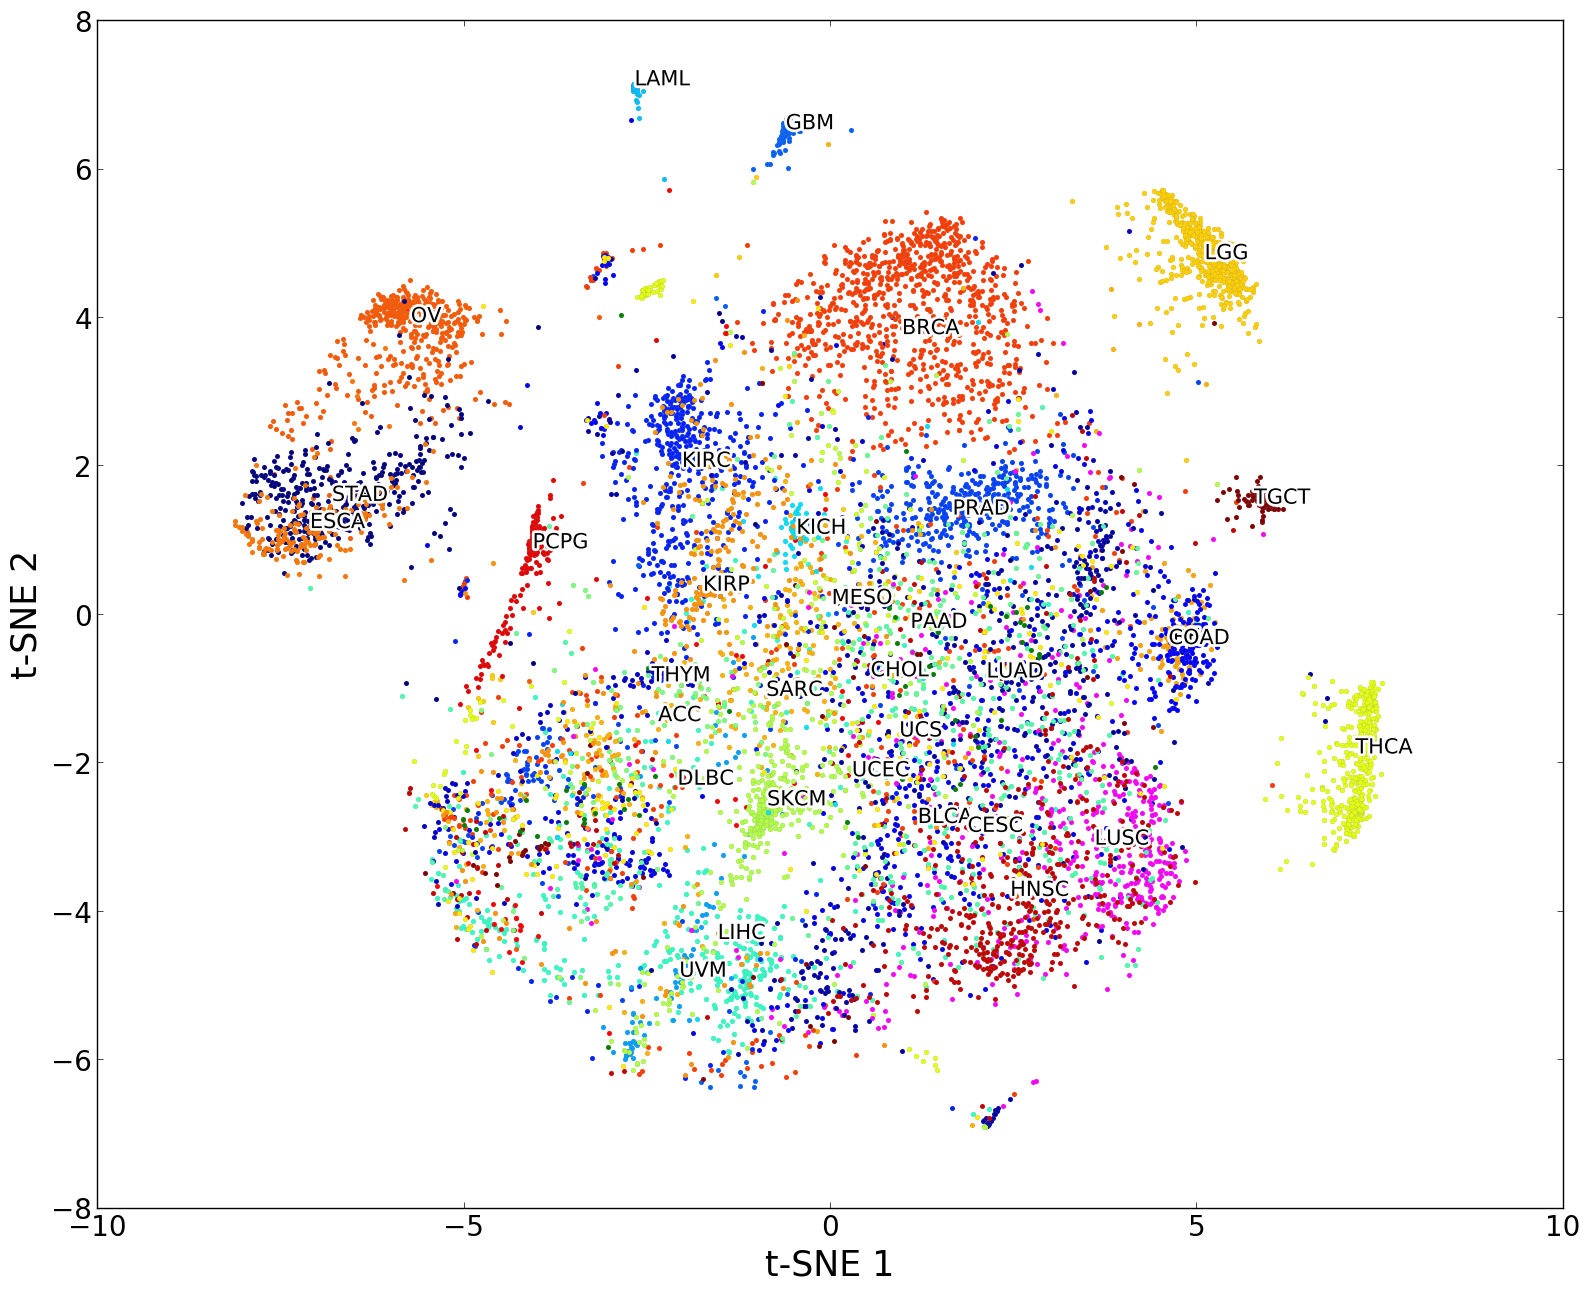

In [42]:
with open('./static/colors_for_33_cancer_types_tsne.pkl', 'rb') as inf:
    colors_dd = pickle.load(inf)

fig = plt.figure(figsize=(16, 13))
ax = fig.add_subplot(111)


for k, d in enumerate(df_embedded.disease.unique()):
    _df = df_embedded.query('disease == "{0}"'.format(d))
    ax.scatter(_df[0].values, _df[1].values, c=colors_dd[d], s=13, linewidths=0.1, edgecolor='gray', label=d)
    xtxt, ytxt = _df[[0, 1]].median().values
    if d == 'DLBC':
        xtxt += 0.1
        ytxt += 0.2
    txt = ax.text(xtxt, ytxt, d, fontsize=15)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=4, foreground="w", alpha=1),
        PathEffects.Normal()])

# ax.set_title('33 diseases (rs: {0})'.format(random_state))

# ax.set_xlim([-7, 7])
# ax.set_ylim([-6.5, 6.5])

ax.set_xlabel('t-SNE 1', fontsize=25)
ax.set_ylabel('t-SNE 2', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.set_title('Visualization of cleavage site profiles in tumor samples', fontsize=20)
plt.tight_layout()

# plt.savefig('./figs/tsne-33-diseases-rs-846558203.jpg', dpi=300)

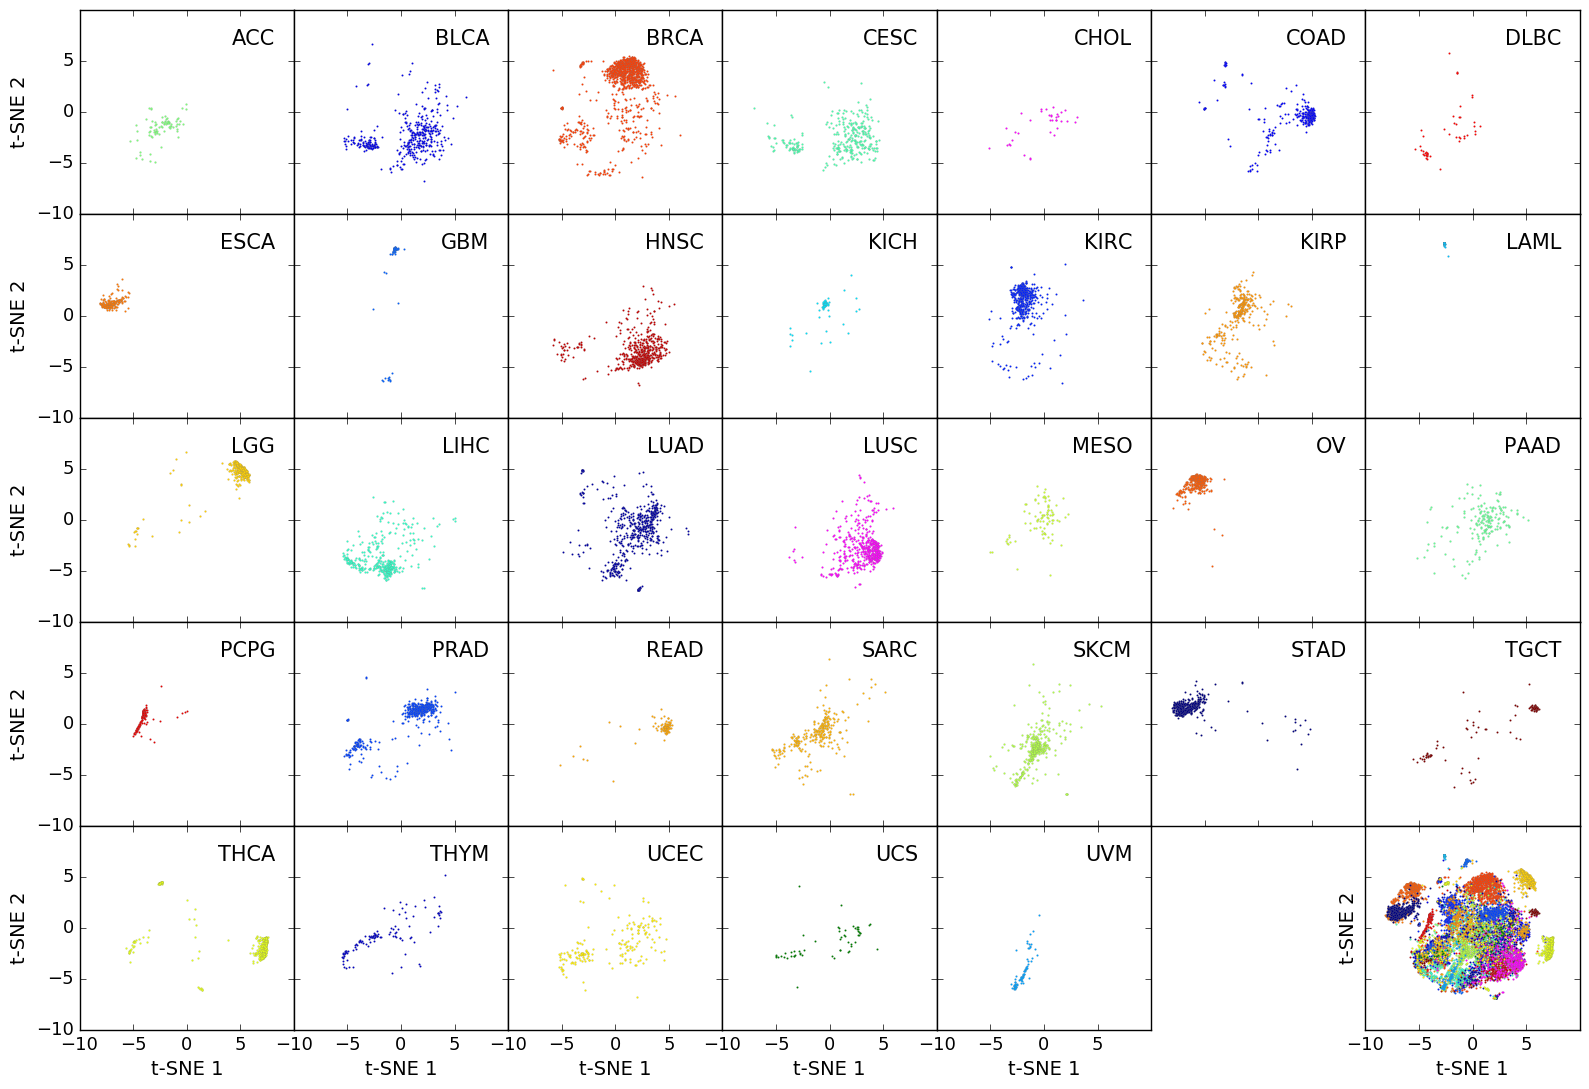

In [52]:
fig, axes = plt.subplots(5, 7, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(16, 11))
axes = axes.ravel()

last_ax = axes[-1]
for k, d in enumerate(sorted(df_embedded.disease.unique())):
    ax = axes[k]
    
    _df = df_embedded.query('disease == "{0}"'.format(d))
    for x in [ax, last_ax]:
        x.scatter(_df[0].values, _df[1].values, c=colors_dd[d], s=1.8, linewidths=0.1, edgecolor='gray', label=d)
    
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    # markerscale=0: don't show marker
    ax.legend(loc='best', framealpha=0, markerscale=0, fontsize=15)
    ax.set_xticks(np.arange(-10, 10, 5))
    ax.set_yticks(np.arange(-10, 10, 5))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)

    if k % 7 == 0:
        ax.set_ylabel('t-SNE 2', fontsize=14)
    if k >= 28:
        ax.set_xlabel('t-SNE 1', fontsize=14)
    
# make empty plot all white
axes[-2].patch.set_facecolor('white')
axes[-2].axis('off')
last_ax.tick_params(axis='both', which='major', labelsize=13)
last_ax.set_xlabel('t-SNE 1', fontsize=14)
last_ax.set_ylabel('t-SNE 2', fontsize=14)

fig.tight_layout()

plt.savefig('/projects/btl/zxue/tasrkleat-TCGA-results/hexamer-patch/condp07.1/figs/tsne-33-diseases-subplots.jpg', dpi=300)